In [1]:
#importing the libraries
import torch 
import torch.nn as nn
from torchvision import datasets,models,transforms,ops
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import os
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sn

In [2]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        if os.path.basename(self.dir_path) == 'train': #transforms for the train dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('/content/drive/MyDrive/Dataset_HW5/dict_train.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\train\\"

        elif os.path.basename(self.dir_path) == 'test': #transforms for the test dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('/content/drive/MyDrive/Dataset_HW5/dict_test.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\test\\"
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): #Saving all the image locations
            image_filenames += [os.path.join(dirpath, file) for file in filenames]
        self.image_filenames = image_filenames    
        self.labels_map = {"bus" : 0, "cat": 1, "pizza" : 2} #Creating hashmap of the class and a number

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        bbox_loc  = self.loc +os.path.basename(os.path.dirname(img_name)) + "\\" + os.path.basename(img_name)
        bbox = torch.Tensor(self.bbox_data[bbox_loc])/256.0
        bbox[2] = bbox[0]+bbox[2]
        bbox[3] = bbox[1]+bbox[3]  
        return image, self.labels_map[os.path.basename(os.path.dirname(img_name))], bbox


In [3]:
#Function to plot the image with its ground truth bounding box
def plot_image(dataset,index):
  img = dataset[index][0] #Getting the image
  [x1,y1,x2,y2] = dataset[index][2]*256.0 #Getting the bounding box coordinates
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous 
  ri = cv2.rectangle(ci,(int(x1),int(y1)),(int(x2),int(y2)),(36,255,12),2) #drawing the bounding box
  plt.imshow(ri)  #plotting the image with the bounding box
  print(dataset[index][1])

In [4]:
#Function to train the model
#Inspired from the HW4 Question
def training(epochs,optimizer,criterion1,criterion2,net,train_data_loader,device):
  rtrain_losses = []
  ctrain_losses = []
  for epoch in range(epochs):
    running_lossc = 0.0
    running_lossr = 0.0
    for i, data in enumerate(train_data_loader):
      inputs, labels,bbox = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      bbox = bbox.to(device)
      optimizer.zero_grad()
      outputs1,outputs2 = net(inputs)
      loss1 = criterion1(outputs1, labels)
      loss2 = criterion2(outputs2, bbox)
      loss1.backward(retain_graph=True)
      loss2.backward()
      optimizer.step()
      running_lossc += loss1.cpu().item()
      running_lossr += loss2.cpu().item()
      if (i + 1) % 100 == 0:
        print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch + 1, i + 1, (running_lossc+running_lossr)/(i+1)))
    ctrain_losses.append(running_lossc/len(train_data_loader.dataset))
    rtrain_losses.append(running_lossr/len(train_data_loader.dataset))
  return net, ctrain_losses, rtrain_losses

In [5]:
#Function to compute the confusion matrix and the mean IOU 
def confusion_matrix(model,test_data_loader):
  matrix = torch.zeros((3,3))
  total_iou = 0.0
  with torch.no_grad():
    for b, (X_test, y_test,bbox_test) in enumerate(test_data_loader):
      model.eval()                
      X_test, y_test, bbox_test = X_test.to(device), y_test.to(device), bbox_test.to(device)               
      # Apply the model                
      y_val,bbox_val = model(X_test) 
      batch_iou = ops.box_iou(bbox_val,bbox_test)
      total_iou += batch_iou.trace()          
               
      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1] 
      for i in range(len(predicted)):
        matrix[predicted[i].cpu(),y_test[i].cpu()] += 1

  mean_iou = total_iou/len(test_data_loader.dataset)
  heat = pd.DataFrame(matrix, index = [i for i in ["bus","cat","pizza"]],
                  columns = [i for i in ["bus","cat","pizza"]])
  heat = heat.astype(int)
  accuracy = (matrix.trace()/matrix.sum())*100
  plt.figure(figsize = (10,7))
  plt.title("Total accuracy is "+str(accuracy.item()))
  
  s = sn.heatmap(heat, annot=True,cmap='Blues',fmt='g')
  s.set(xlabel='Ground label', ylabel='Predicted label')
  print("The IOU mean is " + str(mean_iou.item()))
  
                


In [6]:
#ResBlock architecture 
class ResnetBlock(nn.Module):
  def __init__(self,input_nc,output_nc,stride):
    super().__init__()
    self.conv1  = nn.Conv2d(input_nc,output_nc,kernel_size=3,stride=stride,padding=1)
    self.bn1 = nn.BatchNorm2d(output_nc)
    self.relu1  = nn.ReLU(True)
    self.conv2  = nn.Conv2d(output_nc,output_nc,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(output_nc)
    self.conv3  = nn.Conv2d(input_nc,output_nc,kernel_size=3,stride=stride,padding=1)
    self.bn3 = nn.BatchNorm2d(output_nc)
    self.relu3  = nn.ReLU(True)
    self.down = True if (stride!=1 or input_nc!=output_nc) else False

  def forward(self,x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    
    if self.down: #if the output has different size or number of channels
      identity = self.conv3(identity)
      identity = self.bn3(identity)

    x = x+identity #skip
    x = self.relu3(x)

    return x



In [7]:
#Model architecture containing resblocks
#Inspired by ResNet18
class HW5Net(nn.Module):
  def __init__(self):
    super().__init__()
    #Common layers
    self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3)
    self.bn1  = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(True)
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1)
    #Layers for classification
    self.block1 = ResnetBlock(64,64,1)
    self.block2 = ResnetBlock(64,64,1)
    self.block3 = ResnetBlock(64,128,2)
    self.block4 = ResnetBlock(128,128,1)
    self.block5 = ResnetBlock(128,256,2)
    self.block6 = ResnetBlock(256,256,1)
    self.block7 = ResnetBlock(256,512,2)
    self.block8 = ResnetBlock(512,512,1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,3)
    #Layers for regression
    self.convr1  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr2  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr3  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr4  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.convr5  = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.fr1 = nn.Linear(262144,1024)
    self.fr2 = nn.Linear(1024,4)
    self.sig = nn.Sigmoid()

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    #For classification
    xc = self.block1(x)
    xc = self.block2(xc)
    xc = self.block3(xc)
    xc = self.block4(xc)
    xc = self.block5(xc)
    xc = self.block6(xc)
    xc = self.block7(xc)
    xc = self.block8(xc)
    xc = self.avgpool(xc)
    xc = xc.view(xc.shape[0],-1)
    xc = self.fc(xc)   
    #For regression
    xr = self.relu(self.convr1(x))
    xr = self.relu(self.convr2(xr)) 
    xr = self.relu(self.convr3(xr)) 
    xr = self.relu(self.convr4(xr)) 
    xr = self.relu(self.convr5(xr))
    xr = xr.view(xr.shape[0],-1) 
    xr = self.relu(self.fr1(xr)) 
    xr = self.sig(self.fr2(xr))
    return xc,xr



    

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
train_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW5/train")
test_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW5/test")
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=16)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True,num_workers=16)
print(len(train_dataset))
print(len(test_dataset))

3953
2059


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
#Function to compute complete IOU loss
def IOUloss(a,b):
  ans = ops.complete_box_iou(a,b)
  return 1*a.shape[0]-ans.trace()

In [11]:
model1 = HW5Net()
model1 = model1.to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001, betas = (0.9,0.99))
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

model2 = HW5Net()
model2 = model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001, betas = (0.9,0.99))
criterion3 = nn.CrossEntropyLoss()
criterion4 = IOUloss
epochs = 20

In [12]:
#Number of learnable layers in the model
len(list(model1.parameters()))

116

[epoch: 1, batch:   100] loss: 0.621
[epoch: 1, batch:   200] loss: 0.507
[epoch: 2, batch:   100] loss: 0.345
[epoch: 2, batch:   200] loss: 0.327
[epoch: 3, batch:   100] loss: 0.305
[epoch: 3, batch:   200] loss: 0.292
[epoch: 4, batch:   100] loss: 0.225
[epoch: 4, batch:   200] loss: 0.249
[epoch: 5, batch:   100] loss: 0.202
[epoch: 5, batch:   200] loss: 0.216
[epoch: 6, batch:   100] loss: 0.185
[epoch: 6, batch:   200] loss: 0.178
[epoch: 7, batch:   100] loss: 0.148
[epoch: 7, batch:   200] loss: 0.150
[epoch: 8, batch:   100] loss: 0.105
[epoch: 8, batch:   200] loss: 0.130
[epoch: 9, batch:   100] loss: 0.094
[epoch: 9, batch:   200] loss: 0.093
[epoch: 10, batch:   100] loss: 0.086
[epoch: 10, batch:   200] loss: 0.097
[epoch: 11, batch:   100] loss: 0.067
[epoch: 11, batch:   200] loss: 0.073
[epoch: 12, batch:   100] loss: 0.075
[epoch: 12, batch:   200] loss: 0.058
[epoch: 13, batch:   100] loss: 0.055
[epoch: 13, batch:   200] loss: 0.055
[epoch: 14, batch:   100] loss

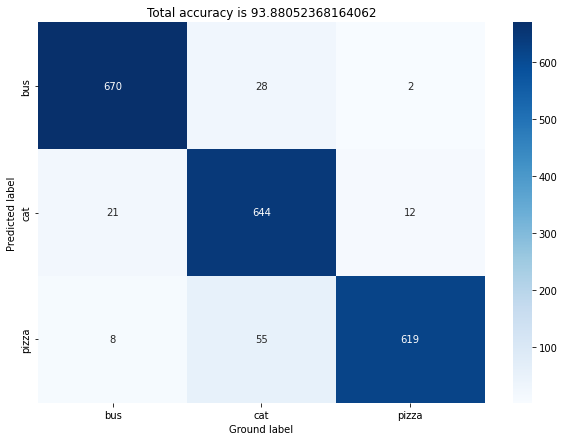

In [14]:
trained_model1,ctrain_losses1, rtrain_losses1 = training(epochs,optimizer1,criterion1,criterion2,model1,train_dataloader,device)
confusion_matrix(trained_model1,test_dataloader) 

[epoch: 1, batch:   100] loss: 8.581
[epoch: 1, batch:   200] loss: 8.048
[epoch: 2, batch:   100] loss: 7.134
[epoch: 2, batch:   200] loss: 7.097
[epoch: 3, batch:   100] loss: 6.876
[epoch: 3, batch:   200] loss: 6.811
[epoch: 4, batch:   100] loss: 6.675
[epoch: 4, batch:   200] loss: 6.535
[epoch: 5, batch:   100] loss: 6.322
[epoch: 5, batch:   200] loss: 6.270
[epoch: 6, batch:   100] loss: 5.976
[epoch: 6, batch:   200] loss: 5.966
[epoch: 7, batch:   100] loss: 5.629
[epoch: 7, batch:   200] loss: 5.586
[epoch: 8, batch:   100] loss: 5.354
[epoch: 8, batch:   200] loss: 5.309
[epoch: 9, batch:   100] loss: 4.880
[epoch: 9, batch:   200] loss: 4.906
[epoch: 10, batch:   100] loss: 4.719
[epoch: 10, batch:   200] loss: 4.656
[epoch: 11, batch:   100] loss: 4.442
[epoch: 11, batch:   200] loss: 4.391
[epoch: 12, batch:   100] loss: 3.998
[epoch: 12, batch:   200] loss: 4.090
[epoch: 13, batch:   100] loss: 3.820
[epoch: 13, batch:   200] loss: 3.810
[epoch: 14, batch:   100] loss

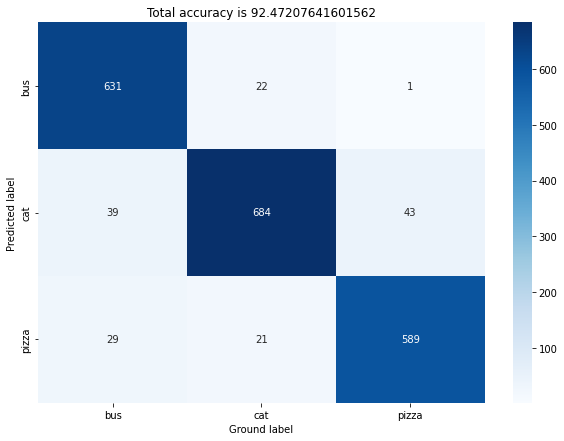

In [13]:
trained_model2,ctrain_losses2, rtrain_losses2 = training(epochs,optimizer2,criterion3,IOUloss,model2,train_dataloader,device)
confusion_matrix(trained_model2,test_dataloader) 

In [16]:
torch.save(trained_model1.state_dict(), "MSE.pt")
torch.save(trained_model2.state_dict(), "IOU.pt")